In [ ]:
from google.colab import drive
drive.mount('/content/d')

Mounted at /content/d


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

RANDOM_STATE = 42

<ins>**PROBLEM SETTING**</ins> This small dataset contains symptoms records for 10 deseases. The task is to predict a desease based on the a patient's description of his codition.

In [ ]:
!unzip 'd/My Drive/nn/_5/diagnosis.zip'

Archive:  d/My Drive/nn/_5/diagnosis.zip
  inflating: Болезни/Дуоденит.txt  
  inflating: Болезни/Эзофагит.txt  
  inflating: Болезни/Аппендицит.txt  
  inflating: Болезни/Гепатит.txt  
  inflating: Болезни/Энтерит.txt  
  inflating: Болезни/Панкреатит.txt  
  inflating: Болезни/Колит.txt  
  inflating: Болезни/Гастрит.txt  
  inflating: Болезни/Язва.txt  
  inflating: Болезни/Холицестит.txt  


Example of what a file contains:

In [ ]:
!cat 'Болезни/Дуоденит.txt'

боль в эпигастральной области,
тошнота,
рвота, 
общая слабость, 
болезненность при пальпации в эпигастральной области, 
слабость,
повышение температуры. 

дискомфорт и боль в верхних отделах живота,
повышенная утомляемость, 
снижение физических и умственных способностей,
раздражительность,
слабость,
капризность, 
головокружения,
боль в голове,
тошнота,
рвота,
отрыжка, 
Учащенное сердцебиение,
снижение аппетита,
метеоризм,
вздутие живота

боль в эпигастральной области,
тошнота,
рвота, 
общая слабость, 
болезненность при пальпации в эпигастральной области

сильная тошнота, 
частая и обильная рвота,
слабость
быстрая утомляемость, 
боль в подложечной области


боль или чувство дискомфорта в области желудка, 
тошнота и рвота;
потеря аппетита;
желудочные кровотечения


Болевые ощущения в подложечной области;
Быстрая утомляемость,
слабость, 
головокружение;
Повышение температуры;
Отсутствие аппетита;
Неприятный привкус во рту;
Тошнота,
газообразование, 
чувство переполненного желудка;
Нарушен

In [ ]:
MAX_WORDS_COUNT = 2000
MAX_LEN = 15
SYMBOLS_TO_FILTER = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
BATCH_SIZE = 3

### TEXT PRERPOCESSING

1. Collect texts from the dataset:

In [ ]:
inputFolder = 'Болезни/'

# collect the deseases names
labelNames = [fl.split('.')[0] for fl in os.listdir(inputFolder)]

def splitList(myList, delim):
    '''
    get each record from a single file
    that is separated by some delimeter
    '''
    res, subl = [], []
    for item in myList:
        if item in delim:
            res.append(subl)
            subl = []
        else:
            subl.append(item)
    if subl:
        res.append(subl)

    return res

def getData(labelNames, inputFolder):
    '''
    collect the data to list and split
    to features (texts) and labels (desease)
    '''
    data = {}
    for diag in labelNames:
        with open(inputFolder + diag + '.txt') as fl:
            contents = fl.readlines()
            data[f'{diag}'] = splitList(contents, ", '\n")
            data[diag] = [i for i in data[diag] if i != []] # drop empty records
        print(f'{diag} contains {len(data[diag])} records')

    texts, labels = [], []
    for k, v in data.items():
        for rec in v:
            texts.append(rec)
            labels.append(k)

    return data, texts, labels

data, texts, labels = getData(labelNames, inputFolder)

print(f'in total {len(texts)} records with {len(labels)} labels')

Язва contains 21 records
Гепатит contains 24 records
Дуоденит contains 23 records
Колит contains 44 records
Гастрит contains 15 records
Эзофагит contains 31 records
Энтерит contains 18 records
Аппендицит contains 21 records
Панкреатит contains 31 records
Холицестит contains 23 records
in total 251 records with 251 labels


The texts are quite messy:

In [ ]:
print(texts[3])

['боль в животе\n', 'Боль возникает в середине живота («под ложечкой»), никуда, как правило, не отдает\n', 'Болевой синдром. Возникает в верхней части живота, носит непостоянный характер. \n', 'Изжога\n', 'Рвота\n', 'тошнота\n', 'Отсутствие аппетита\n']


2. Split the sentence strings into tokens, remove punctuations and force lower case:

In [ ]:
def flat(nestedList): # flat the nested lists
    return [item.lower() for sublist in nestedList for item in sublist]

def splt(inpList): # split into tokens
    return flat([line.split() for line in inpList])

def cleanTokens(texts): # remove punctuations
    rmv = str.maketrans('', '', SYMBOLS_TO_FILTER)

    for i in range(len(texts)):
        texts[i] = splt(texts[i])
        texts[i] = [w.translate(rmv) for w in texts[i]]
        try:
            texts[i].remove('')
        except ValueError:
            continue

    return texts

texts = cleanTokens(texts)
print(texts[3])

['боль', 'в', 'животе', 'боль', 'возникает', 'в', 'середине', 'живота', '«под', 'ложечкой»', 'никуда', 'как', 'правило', 'не', 'отдает', 'болевой', 'синдром', 'возникает', 'в', 'верхней', 'части', 'живота', 'носит', 'непостоянный', 'характер', 'изжога', 'рвота', 'тошнота', 'отсутствие', 'аппетита']


Dump the data into dataframe to make it easier to handle

In [ ]:
df = pd.DataFrame(columns=['texts', 'labels'])
df.texts, df.labels = [' '.join(t) for t in texts], labels

3. Initialize Keras tokenizer and make the vocabulary based on the word indices frequency:

In [ ]:
tokenizer = Tokenizer(
    num_words = MAX_WORDS_COUNT, 
    # filters = symbolsToFilter, 
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(df.texts.values)
print(f'the vocabulary size: {len(tokenizer.word_index.items())}')

the vocabulary size: 2058


4. Encode the labels

In [ ]:
def encode(labels):
    encoder = LabelEncoder()
    encoder.fit(df.labels)
    labelsEncoded = encoder.transform(df.labels)
    y = utils.to_categorical(labelsEncoded, len(set(df.labels)))
    print(y.shape)

    return encoder, y

encoder, y = encode(labels)

(251, 10)


5. Convert the texts to sequences:

In [ ]:
def textToSeq(texts):
    xSeq = tokenizer.texts_to_sequences(df.texts)
    xSeq = np.array(xSeq, dtype=object)
    x = pad_sequences(xSeq, maxlen=MAX_LEN, padding='pre', truncating='pre')

    return x

x = textToSeq(texts)

Now the dataset is ready to be passed to train test split. The tricky part is that we have to split within the labels in the ame proportion to avoid model misfit:

In [ ]:
def splitData(x, y, labels):

    # get dictionary with number of records by a label
    cntVal = {}
    for label in set(labels):
        cntVal[label] = len(data[label])
    print(cntVal)

    # initialize the arrays for train and test samples
    # consider the correct dimension to pass to the model
    xTrain, xTest = np.array(np.zeros(MAX_LEN)), np.array(np.zeros(MAX_LEN))
    yTrain, yTest = np.array(np.zeros(len(labelNames))), np.array(np.zeros(len(labelNames)))

    xTrain, xTest = xTrain[np.newaxis, ...], xTest[np.newaxis, ...] 
    yTrain, yTest = yTrain[np.newaxis, ...], yTest[np.newaxis, ...] 

    # split while looping through the labels 
    cnt = 0
    for i in range(len(labelNames)):
        n = cntVal[labelNames[i]]
        xTr, xTs, yTr, yTs = train_test_split(x[cnt:cnt+n], y[cnt:cnt+n], test_size=0.2, random_state= RANDOM_STATE)
        xTrain, xTest = np.concatenate((xTrain, xTr)), np.concatenate((xTest, xTs))
        yTrain, yTest = np.concatenate((yTrain, yTr)), np.concatenate((yTest, yTs))
        cnt += n

    # drop the rows required to initialize the array
    xTrain, xTest = np.delete(xTrain, (0), axis=0), np.delete(xTest, (0), axis=0)
    yTrain, yTest = np.delete(yTrain, (0), axis=0), np.delete(yTest, (0), axis=0)

    return xTrain, xTest, yTrain, yTest

xTrain, xTest, yTrain, yTest = splitData(x, y, labels)

{'Энтерит': 18, 'Панкреатит': 31, 'Дуоденит': 23, 'Холицестит': 23, 'Эзофагит': 31, 'Гастрит': 15, 'Колит': 44, 'Язва': 21, 'Гепатит': 24, 'Аппендицит': 21}


To check the model's score and accuracy while prediction the test we need a custom function:

In [ ]:
def totalScore(model, xTest, yTest):
    res = dict(zip(labelNames, [0]*len(labelNames)))
    truth = [np.argmax(t) for t in yTest]
    preds = [np.argmax(p) for p in model.predict(xTest)]
    names = encoder.inverse_transform(preds).astype(object)

    for i in range(len(truth)):
        if truth[i] == preds[i]:
            res[names[i]] += 1
    
    print(res)

    return f'total recognition score: {round(sum(res.values()) / len(truth) * 100, 2)}%'

### MODEL FIT

Now let's try models with different layers:

Epoch 1/15
66/66 [==============================] - 2s 6ms/step - loss: 2.7356 - accuracy: 0.1020 - val_loss: 2.2983 - val_accuracy: 0.0909
Epoch 2/15
66/66 [==============================] - 0s 4ms/step - loss: 2.5776 - accuracy: 0.1327 - val_loss: 2.3086 - val_accuracy: 0.1636
Epoch 3/15
66/66 [==============================] - 0s 4ms/step - loss: 2.5917 - accuracy: 0.1173 - val_loss: 2.3120 - val_accuracy: 0.1455
Epoch 4/15
66/66 [==============================] - 0s 4ms/step - loss: 2.3266 - accuracy: 0.2245 - val_loss: 2.3097 - val_accuracy: 0.1636
Epoch 5/15
66/66 [==============================] - 0s 5ms/step - loss: 2.2704 - accuracy: 0.2092 - val_loss: 2.2760 - val_accuracy: 0.2545
Epoch 6/15
66/66 [==============================] - 0s 4ms/step - loss: 2.2067 - accuracy: 0.2449 - val_loss: 2.2486 - val_accuracy: 0.2000
Epoch 7/15
66/66 [==============================] - 0s 4ms/step - loss: 2.0990 - accuracy: 0.2857 - val_loss: 2.2422 - val_accuracy: 0.2364
Epoch 8/15
66/66 [==

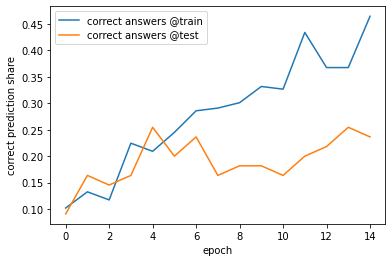

{'Язва': 1, 'Гепатит': 1, 'Дуоденит': 2, 'Колит': 3, 'Гастрит': 0, 'Эзофагит': 3, 'Энтерит': 0, 'Аппендицит': 0, 'Панкреатит': 1, 'Холицестит': 2}


'total recognition score: 23.64%'

In [ ]:
# EMBEDDING + DENSE

model = Sequential()
model.add(Embedding(MAX_WORDS_COUNT, 20, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(len(set(labels)), activation='softmax'))

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs = 15,
    batch_size = BATCH_SIZE,
    validation_data = (xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

totalScore(model, xTest, yTest)

Epoch 1/8
66/66 [==============================] - 5s 14ms/step - loss: 3.1541 - accuracy: 0.1173 - val_loss: 2.2997 - val_accuracy: 0.1636
Epoch 2/8
66/66 [==============================] - 0s 7ms/step - loss: 3.0750 - accuracy: 0.0918 - val_loss: 2.3109 - val_accuracy: 0.1636
Epoch 3/8
66/66 [==============================] - 0s 7ms/step - loss: 2.7408 - accuracy: 0.1429 - val_loss: 2.3108 - val_accuracy: 0.1636
Epoch 4/8
66/66 [==============================] - 0s 7ms/step - loss: 2.7014 - accuracy: 0.1582 - val_loss: 2.2936 - val_accuracy: 0.1636
Epoch 5/8
66/66 [==============================] - 0s 7ms/step - loss: 2.5615 - accuracy: 0.1888 - val_loss: 2.3076 - val_accuracy: 0.1818
Epoch 6/8
66/66 [==============================] - 0s 7ms/step - loss: 2.4512 - accuracy: 0.2398 - val_loss: 2.3130 - val_accuracy: 0.2182
Epoch 7/8
66/66 [==============================] - 0s 7ms/step - loss: 2.3932 - accuracy: 0.2704 - val_loss: 2.2513 - val_accuracy: 0.2182
Epoch 8/8
66/66 [=========

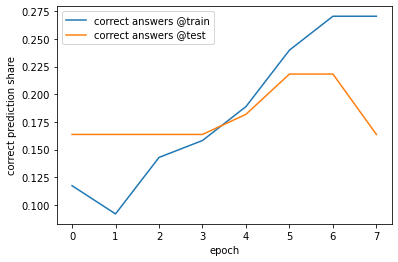

{'Язва': 0, 'Гепатит': 0, 'Дуоденит': 1, 'Колит': 4, 'Гастрит': 0, 'Эзофагит': 1, 'Энтерит': 0, 'Аппендицит': 2, 'Панкреатит': 0, 'Холицестит': 1}


'total recognition score: 16.36%'

In [ ]:
# EMBEDDING + LSTM

model = Sequential()
model.add(Embedding(MAX_WORDS_COUNT, 40, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.4))
model.add(BatchNormalization())
model.add(LSTM(4, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(set(labels)), activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=BATCH_SIZE,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

totalScore(model, xTest, yTest)

Epoch 1/20
66/66 [==============================] - 14s 8ms/step - loss: 3.0424 - accuracy: 0.0765 - val_loss: 2.3067 - val_accuracy: 0.0909
Epoch 2/20
66/66 [==============================] - 0s 5ms/step - loss: 2.4469 - accuracy: 0.2296 - val_loss: 2.3431 - val_accuracy: 0.1091
Epoch 3/20
66/66 [==============================] - 0s 5ms/step - loss: 1.7970 - accuracy: 0.3673 - val_loss: 2.3689 - val_accuracy: 0.0909
Epoch 4/20
66/66 [==============================] - 0s 5ms/step - loss: 1.4622 - accuracy: 0.5102 - val_loss: 2.4009 - val_accuracy: 0.1273
Epoch 5/20
66/66 [==============================] - 0s 5ms/step - loss: 1.2625 - accuracy: 0.5867 - val_loss: 2.3601 - val_accuracy: 0.1273
Epoch 6/20
66/66 [==============================] - 0s 5ms/step - loss: 0.9407 - accuracy: 0.7245 - val_loss: 2.3539 - val_accuracy: 0.1455
Epoch 7/20
66/66 [==============================] - 0s 5ms/step - loss: 0.7835 - accuracy: 0.8163 - val_loss: 2.2979 - val_accuracy: 0.1818
Epoch 8/20
66/66 [=

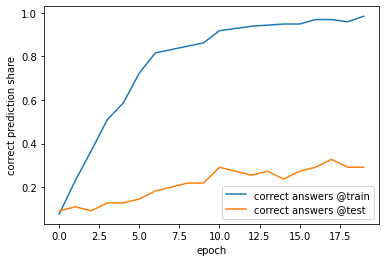

{'Язва': 3, 'Гепатит': 0, 'Дуоденит': 1, 'Колит': 4, 'Гастрит': 3, 'Эзофагит': 3, 'Энтерит': 0, 'Аппендицит': 0, 'Панкреатит': 1, 'Холицестит': 1}


'total recognition score: 29.09%'

In [ ]:
# EMBEDDING + Conv1D

model = Sequential()
model.add(Embedding(MAX_WORDS_COUNT, 40, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(Conv1D(
    filters = 20, # number of output filters in the convolution
    kernel_size = 2, # length of a filter
    activation='relu'
))
model.add(Conv1D(
    filters = 20,
    kernel_size = 2,
    activation='relu'
))
model.add(MaxPooling1D(2)) # stride 2
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(set(labels)), activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

totalScore(model, xTest, yTest)

Epoch 1/5
66/66 [==============================] - 3s 14ms/step - loss: 2.9012 - accuracy: 0.0867 - val_loss: 2.2749 - val_accuracy: 0.1636
Epoch 2/5
66/66 [==============================] - 1s 8ms/step - loss: 2.5276 - accuracy: 0.2143 - val_loss: 2.3987 - val_accuracy: 0.1091
Epoch 3/5
66/66 [==============================] - 1s 8ms/step - loss: 2.7141 - accuracy: 0.1582 - val_loss: 2.5456 - val_accuracy: 0.1091
Epoch 4/5
66/66 [==============================] - 1s 8ms/step - loss: 2.4055 - accuracy: 0.1990 - val_loss: 2.7815 - val_accuracy: 0.1091
Epoch 5/5
66/66 [==============================] - 1s 8ms/step - loss: 2.3585 - accuracy: 0.2245 - val_loss: 2.6280 - val_accuracy: 0.0909


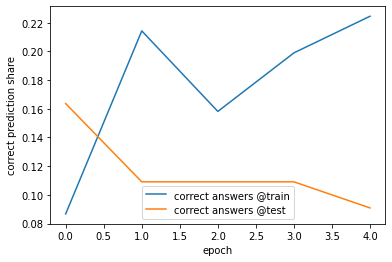

{'Язва': 0, 'Гепатит': 5, 'Дуоденит': 0, 'Колит': 0, 'Гастрит': 0, 'Эзофагит': 0, 'Энтерит': 0, 'Аппендицит': 0, 'Панкреатит': 0, 'Холицестит': 0}


'total recognition score: 9.09%'

In [ ]:
# EMBEDDING + DENSE + LSTM + CONV1D

model = Sequential()
model.add(Embedding(MAX_WORDS_COUNT, 40, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())

model.add(LSTM(4, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())

model.add(Conv1D(
    filters = 20,
    kernel_size = 2,
    activation='relu'
))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(len(set(labels)), activation='softmax'))

model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

totalScore(model, xTest, yTest)

The best result of 30% we have achieved by applying embedding and convolution layers. It is quite low but let's keep in mind that the dataset contains only 250 records which is extremely low.

Potential actions to improve the model score (presumably for a small value):

[_] use the vocabluary based on less frequent words

[_] try a different sequence length and a batch size.